In [21]:
from io import open
import pickle
import sys
sys.path.insert(0,'./zipped_files_from_www')
sys.path.insert(0,'./Boyu')
from posterior import *
from sklearn.metrics import average_precision_score,precision_recall_fscore_support,confusion_matrix, roc_curve, auc, classification_report, average_precision_score, accuracy_score
#from random_slice import *
cats = ["Business & Industrial","Home & Garden","Travel","Arts & Entertainment","Sports","Food & Drink","Pets & Animals","Health","Shopping","Finance","Adult","Beauty & Fitness","News","Books & Literature","Online Communities","Law & Government","Sensitive Subjects","Science","Hobbies & Leisure","Games","Jobs & Education","Autos & Vehicles","Computers & Electronics","People & Society","Reference","Internet & Telecom","Real Estate"]

In [22]:

def random_split(low_list,notlow_list,split_ratio=4.0/5):

    num_low, num_notlow = len(low_list), len(notlow_list)
    low_train_indices, notlow_train_indices = np.random.choice(num_low,size = int(num_low*split_ratio),replace=False), np.random.choice(num_notlow,size = int(num_notlow*split_ratio),replace=False)
    train_low, test_low, train_notlow, test_notlow = [],[],[],[]
    for i in range(num_low):
        if i in low_train_indices:
            train_low.append(low_list[i][1])
        else:
            test_low.append(low_list[i][1])
            
    for i in range(num_notlow):
        if i in notlow_train_indices:
            train_notlow.append(notlow_list[i][1])
        else:
            test_notlow.append(notlow_list[i][1])
            
    return train_low, test_low, train_notlow, test_notlow
            
        
    

In [23]:
with open('Boyu/lambda_vectors_with_user_ID.pkl', 'rb') as f:
	(low_list, notlow_list) = pickle.load(f)

In [24]:
train_low, test_low, train_notlow, test_notlow = random_split(low_list,notlow_list)


In [25]:
train_lambda, train_label = np.array(train_low+train_notlow), np.array([1 for i in train_low]+[0 for j in train_notlow])
test_lambda, test_label = np.array(test_low+test_notlow), np.array([1 for i in test_low]+[0 for j in test_notlow])
print(test_label)

[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


In [26]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


simMatrix = np.load('zipped_files_from_www/sim_mat.npy')

print(simMatrix.shape)
print(is_pos_def(simMatrix))
print('==================')
simMatrix2 = np.loadtxt("zipped_files_from_www/similarity_matrix.csv", dtype='float32', delimiter=',')
print(is_pos_def(simMatrix2))
cov_W = simMatrix2
cov_W_inv = inv(cov_W)

# cov_W = (1- simMatrix) + np.identity(len(cats))
mu_W = np.zeros(len(cats))
print(mu_W.shape)
print(cov_W.shape)
print('Shape: similarity matrix',simMatrix.shape)
print('Shape: covariance matrix',cov_W.shape)
print(is_pos_def(cov_W))
#print(cov_W)

(27, 27)
True
True
(27,)
(27, 27)
Shape: similarity matrix (27, 27)
Shape: covariance matrix (27, 27)
True


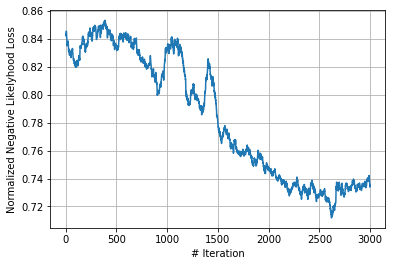

In [32]:
bmodel = Bayes_model(train_lambda,train_label ,cov_W,mu_W)
samples_w, samples_sigma = bmodel.metropolis_hastings()

In [34]:
precisions = []
recalls = []
f1s = []

total_miss = []
class1_precisions = []
class0_precisions = []

class1_f1s = []
class0_f1s = []

class1_recalls = []
class0_recalls = []

class1_miss = []
class0_miss = []


w = np.mean(samples_w, axis=0)
sig = np.mean(samples_sigma)
p = sigmoid(np.dot(test_lambda, w) + sig*np.random.normal())
# y_hat = [np.random.binomial(1, i) for i in p]
y_hat = []
for i in p:
    if i <= 0.5:
        y_hat.append(1)
    else:
        y_hat.append(0)
print('===================')
for i in range(len(y_hat)):
    print('predicted:', y_hat[i], '\t\t true:',test_label[i])

# print y_hat
cr = classification_report(test_label, y_hat)
cm = confusion_matrix(test_label, y_hat)
print(cr)
print(cm)
num_class0_miss = cm[0][1] 
num_class1_miss = cm[1][0]
l= cr.split('avg / total')[-1].strip().split()
#print(l)
#avg_prec, avg_recal,avg_f1,_ = cr.split('avg / total')[-1].strip().split()

clf_rep = precision_recall_fscore_support(test_label, y_hat)
out_dict = {
    "precision" :clf_rep[0].round(2)
    ,"recall" : clf_rep[1].round(2)
    ,"f1-score" : clf_rep[2].round(2)
    ,"support" : clf_rep[3]
}
print(out_dict)
class0_recalls.append(out_dict['recall'][0])
class0_f1s.append(out_dict['f1-score'][0])
class0_precisions.append(out_dict['precision'][0])
class0_miss.append(num_class0_miss)

class1_recalls.append(out_dict['recall'][1])
class1_f1s.append(out_dict['f1-score'][1])
class1_precisions.append(out_dict['precision'][1])
class1_miss.append(num_class1_miss)
total_miss.append(num_class0_miss+num_class1_miss)

# precisions.append(float(avg_prec))
# recalls.append(float(avg_recal))
# f1s.append(float(avg_f1))

predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 1 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 1
predicted: 0 		 true: 0
predicted: 0 		 true: 0
predicted: 0 		 true: 0
predicted: 0 		 true: 0
predicted: 0 		 true: 0
predicted: 0 		 true: 0
predicted: 0 		 true: 0
predicted: 0 		 true: 0
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         8
           1       1.00      0.09      0.17        11

   micro avg       0.47      0.47      0.47        19
   macro avg       0.72      0.55      0.39        19
weighted avg       0.77      0.47      0.36        19

[[ 8  0]
 [10  1]]
{'precision': array([0.44, 1.  ]), 'recall': array([1.  , 0.09]), 'f1-score': array([0.62, 0.17]), 'support': array([ 8, 11])}
